In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from datasets import Dataset, load_from_disk
import torch.nn.functional as F

import numpy as np
import pandas as pd

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
path_final_test = './data/final_test/'

In [4]:
BATCH_SIZE = 128

In [5]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])])

In [6]:
# 0 - anomalies

test_dataset = ImageFolder(path_final_test, preprocess)

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1751
    Root location: ./data/final_test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
next(iter(testDataLoader))[1]

tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1])

In [14]:
resnet34 = models.resnet34(weights=None)
class CustomFC(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.fc1 = nn.Linear(in_features=in_features, out_features=out_features)
        
    def forward(self, x):
        return self.fc1(x), x
    
resnet34.fc = CustomFC(512,8)
resnet34.to(device)

resnet34.load_state_dict(torch.load('model_best_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [15]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n, m, p, b):
        super().__init__()
        self.e1 = torch.nn.Linear(n, m)
        self.e2 = torch.nn.Linear(m, p)
        self.e3 = torch.nn.Linear(p, b)
        self.dec3 = torch.nn.Linear(b, p)
        self.dec2 = torch.nn.Linear(p, m)
        self.dec1 = torch.nn.Linear(m, n)
        
    def forward(self, x):
        x = self.e1(x)
        x = self.e2(F.relu(x))
        encoded = self.e3(F.relu(x))
        x = self.dec3(encoded)
        x = self.dec2(F.relu(x))
        x = self.dec1(F.relu(x))
        return x

In [16]:
# del model_auto

model_auto = AutoEncoder(512, 256, 128, 32)
model_auto.to(device)
model_auto.load_state_dict(torch.load('best_model_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [17]:
def sep_mod_acc(model1, model2, dataloader_test, er_mean_rat, errors = False):
    loss_fn = torch.nn.MSELoss(reduction='none')
    model1.eval()
    model2.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    big_ones = 0.0
    tot_positive = 0.0
    err_p = []
    err_n = []
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, emb = model1(x)
            x_pr = model2(emb)
            error = torch.mean(loss_fn(x_pr, emb), dim=1)/0.0026712
            acc_test += torch.sum(torch.where(error>er_mean_rat,0,1) == target).item()
            tot_test += target.size(0)
            err_p.extend(list(error[target==1].cpu().tolist()))
            err_n.extend(list(error[target==0].cpu().tolist()))
            
            
            # outputs = outputs.sigmoid().max(dim=1).values

        #     big_ones += torch.sum(outputs.round()).item()
        #     pred.extend(outputs.round().cpu().tolist())
        #     trg.extend(target.cpu().tolist())
        #     tot_test += target.size(0)
        #     tot_positive += torch.sum(target).item()
        # print(f'{er_mean_rat}Test accuracy: {round(acc_test/tot_test*100,2)}%')
        # print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        # print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
    if errors: return err_p, err_n
    return round(acc_test/tot_test*100,2)#, round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})

In [52]:
res = []
for i in range(1,70):
    res.append(sep_mod_acc(resnet34, model_auto, testDataLoader, i*.1))
max(res)


60.14

In [53]:
res

[51.97,
 51.97,
 51.97,
 52.26,
 53.11,
 54.65,
 55.91,
 56.08,
 56.31,
 58.31,
 58.71,
 59.79,
 60.14,
 59.85,
 60.08,
 59.28,
 58.08,
 57.8,
 56.71,
 55.34,
 54.37,
 53.06,
 52.77,
 51.86,
 51.68,
 51.46,
 51.06,
 51.0,
 51.06,
 50.66,
 50.37,
 50.09,
 49.91,
 49.91,
 49.69,
 49.34,
 49.29,
 49.06,
 49.06,
 49.0,
 48.89,
 48.72,
 48.43,
 48.43,
 48.32,
 48.32,
 48.26,
 48.37,
 48.32,
 48.26,
 48.32,
 48.26,
 48.26,
 48.26,
 48.26,
 48.26,
 48.26,
 48.26,
 48.26,
 48.26,
 48.2,
 48.14,
 48.14,
 48.14,
 48.14,
 48.14,
 48.14,
 48.2,
 48.14]

(0.3, 6)

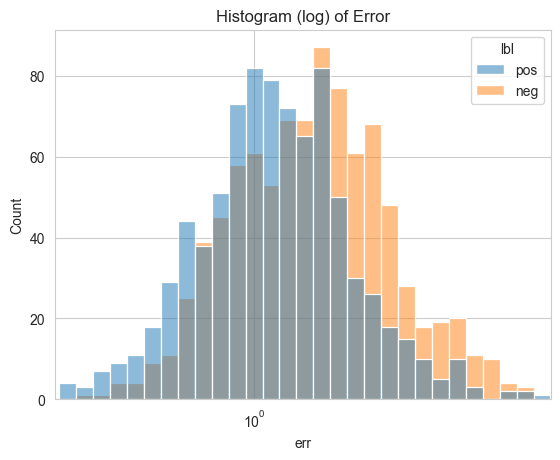

In [23]:
err_p, err_n = sep_mod_acc(resnet34, model_auto, testDataLoader, 1.3, True)

import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.DataFrame({'err':err_p})
df2 = pd.DataFrame({'err':err_n})
df1['lbl'] = 'pos'
df2['lbl'] = 'neg'
df = pd.concat([df1, df2], axis=0)

sns.histplot(data=df, x='err', hue='lbl', log_scale=True)
plt.title(f'Histogram (log) of Error')
plt.xlim(0.3,6)

In [83]:
mtr = []

for i in [16,32,64]:
    del model_auto
    model_auto = AutoEncoder(512, 256, 128, i)
    model_auto.to(device)
    model_auto.load_state_dict(torch.load(f'best_model_autoenc{i}_resnet34.pt', map_location=device, weights_only=False))
    res = []
    for j in range(1,70):
        res.append((sep_mod_acc(resnet34, model_auto, testDataLoader, j*.1), j*0.1))
    acc = [k[0] for k in res]
    print(acc)
    par = [k[1] for k in res]
    acc_max = max(acc)
    ind_max = acc.index(acc_max)
    par_max = par[ind_max]
    mtr.append((i,acc_max, par_max))
    
auto_sep = pd.DataFrame({'dim':[i[0] for i in mtr],'acc':[i[1] for i in mtr],'param':[i[2] for i in mtr]})
print(auto_sep)

[51.97, 51.97, 51.97, 53.06, 53.57, 54.65, 56.08, 57.4, 56.14, 56.77, 56.65, 57.17, 57.74, 56.77, 55.85, 55.4, 55.34, 54.08, 53.57, 53.46, 52.54, 51.91, 51.63, 51.34, 51.11, 50.94, 50.94, 50.89, 50.83, 50.83, 50.49, 50.14, 49.86, 49.8, 49.51, 49.17, 49.06, 48.94, 48.89, 48.94, 48.83, 48.77, 48.72, 48.72, 48.66, 48.54, 48.49, 48.49, 48.49, 48.49, 48.54, 48.54, 48.49, 48.49, 48.43, 48.43, 48.37, 48.26, 48.26, 48.26, 48.26, 48.2, 48.2, 48.2, 48.2, 48.2, 48.14, 48.09, 48.14]
[51.97, 51.97, 51.97, 52.26, 53.11, 54.65, 55.91, 56.08, 56.31, 58.31, 58.71, 59.79, 60.14, 59.85, 60.08, 59.28, 58.08, 57.8, 56.71, 55.34, 54.37, 53.06, 52.77, 51.86, 51.68, 51.46, 51.06, 51.0, 51.06, 50.66, 50.37, 50.09, 49.91, 49.91, 49.69, 49.34, 49.29, 49.06, 49.06, 49.0, 48.89, 48.72, 48.43, 48.43, 48.32, 48.32, 48.26, 48.37, 48.32, 48.26, 48.32, 48.26, 48.26, 48.26, 48.26, 48.26, 48.26, 48.26, 48.26, 48.26, 48.2, 48.14, 48.14, 48.14, 48.14, 48.14, 48.14, 48.2, 48.14]
[51.97, 51.97, 52.08, 52.71, 53.63, 55.11, 55

In [85]:
auto_sep.to_csv('auto_sep_mtrcs.csv', index=False, header=True)

In [70]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, latent_dim*2), # 2 for mean and variance.
        )
        # self.parametr = nn.Linear(latent_dim, 2 * latent_dim)
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        # x = self.parametr(lat_x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        # compute loss terms 
        loss_recon = F.mse_loss(recon_x, x, reduction='none').sum(-1).sqrt()#.mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal)#.mean()
        # loss_kl = F.kl_div(z, lat_x, reduction='none').mean()
                
        loss = loss_recon + loss_kl
        
        return loss.mean(),loss_recon

In [71]:
def sep_mod_acc_var(model1, model2, dataloader_test, er_mean_rat):
    loss_fn = torch.nn.MSELoss(reduction='none')
    model1.eval()
    model2.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    big_ones = 0.0
    tot_positive = 0.0
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, emb = model1(x)
            err = model2(emb)[1]
            error = err/5
            acc_test += torch.sum(torch.where(error>er_mean_rat,1.,0.) == target).item() # what???
            tot_test += target.size(0)
            
            
            # outputs = outputs.sigmoid().max(dim=1).values

        #     big_ones += torch.sum(outputs.round()).item()
        #     pred.extend(outputs.round().cpu().tolist())
        #     trg.extend(target.cpu().tolist())
        #     tot_test += target.size(0)
        #     tot_positive += torch.sum(target).item()
        # print(f'{er_mean_rat}Test accuracy: {round(acc_test/tot_test*100,2)}%')
        # print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        # print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
        
    return round(acc_test/tot_test*100,2)#, round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})

In [72]:
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=64).to(device)
model_auto.load_state_dict(torch.load('best_model_var_autoenc64_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [73]:
x = torch.randn((4,512)).to(device)
model_auto(x)

(tensor(22.8456, device='mps:0', grad_fn=<MeanBackward0>),
 tensor([22.1504, 22.8999, 23.1328, 23.1995], device='mps:0',
        grad_fn=<SqrtBackward0>))

In [74]:
res = []
for i in range(1,150):
    a  = sep_mod_acc_var(resnet34, model_auto, testDataLoader, i*.02)
    res.append(a)
    # print(a)
max(res)

68.08

In [75]:
res

[48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.09,
 48.2,
 48.37,
 48.6,
 48.89,
 49.29,
 49.46,
 50.2,
 51.4,
 52.77,
 54.83,
 56.25,
 57.97,
 59.57,
 60.82,
 62.48,
 63.74,
 64.76,
 65.39,
 66.59,
 66.25,
 66.82,
 67.68,
 67.56,
 67.73,
 67.68,
 67.62,
 67.68,
 67.79,
 68.08,
 67.39,
 67.33,
 67.16,
 66.59,
 66.3,
 65.91,
 65.45,
 64.65,
 63.68,
 63.34,
 62.88,
 61.91,
 61.45,
 60.77,
 60.08,
 59.51,
 59.17,
 58.6,
 58.2,
 57.8,
 57.34,
 57.0,
 56.65,
 56.31,
 55.91,
 55.68,
 55.17,
 54.88,
 54.48,
 54.25,
 53.74,
 53.74,
 53.57,
 53.4,
 53.28,
 53.11,
 52.88,
 52.83,
 52.71,
 52.71,
 52.66,
 52.71,
 52.71,
 52.6,
 52.6,
 52.6,
 52.6,
 52.6,
 52.6,
 52.54,
 52.43,
 52.26,
 52.26,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.03,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,


In [76]:
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=32).to(device)
model_auto.load_state_dict(torch.load('best_model_var_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [77]:
res = []
for i in range(1,150):
    a  = sep_mod_acc_var(resnet34, model_auto, testDataLoader, i*.02)
    res.append(a)
    # print(a)
max(res)

67.9

In [78]:
res

[48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.09,
 48.14,
 48.37,
 48.66,
 48.77,
 49.17,
 49.69,
 49.86,
 51.4,
 52.94,
 54.31,
 56.2,
 58.14,
 59.62,
 60.31,
 61.68,
 63.34,
 64.48,
 64.82,
 65.96,
 66.48,
 67.1,
 67.5,
 67.9,
 67.39,
 67.5,
 67.1,
 67.68,
 67.73,
 67.62,
 67.85,
 67.73,
 67.39,
 66.53,
 66.7,
 66.42,
 66.13,
 65.73,
 65.16,
 63.74,
 63.51,
 62.82,
 62.36,
 61.85,
 61.11,
 60.19,
 59.85,
 59.22,
 58.6,
 58.31,
 57.85,
 57.62,
 57.4,
 57.05,
 56.42,
 56.03,
 55.91,
 55.34,
 55.0,
 54.6,
 54.31,
 54.03,
 53.91,
 53.68,
 53.46,
 53.28,
 53.17,
 53.0,
 52.77,
 52.71,
 52.71,
 52.71,
 52.77,
 52.71,
 52.71,
 52.66,
 52.6,
 52.6,
 52.6,
 52.6,
 52.54,
 52.48,
 52.43,
 52.31,
 52.26,
 52.14,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.03,
 52.03,
 52.03,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 

In [80]:
del model_auto
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=16).to(device)
model_auto.load_state_dict(torch.load('best_model_var_autoenc16_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [81]:
res = []
for i in range(1,150):
    a  = sep_mod_acc_var(resnet34, model_auto, testDataLoader, i*.02)
    res.append(a)
    # print(a)
max(res)

67.73

In [82]:
res

[48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.03,
 48.09,
 48.14,
 48.32,
 48.43,
 48.66,
 49.06,
 49.46,
 49.57,
 50.94,
 52.26,
 53.57,
 55.63,
 57.17,
 58.77,
 60.25,
 61.17,
 62.71,
 64.25,
 64.88,
 65.91,
 66.7,
 66.42,
 67.39,
 67.68,
 67.5,
 67.56,
 67.39,
 67.28,
 67.62,
 67.62,
 67.73,
 67.68,
 67.45,
 66.82,
 66.65,
 66.19,
 66.02,
 65.51,
 64.59,
 63.96,
 63.22,
 62.99,
 61.91,
 61.45,
 61.05,
 60.19,
 59.62,
 59.17,
 58.6,
 58.37,
 57.91,
 57.34,
 57.22,
 56.71,
 56.37,
 56.08,
 55.85,
 55.34,
 55.0,
 54.65,
 54.25,
 53.85,
 53.68,
 53.63,
 53.51,
 53.23,
 53.23,
 52.94,
 52.77,
 52.71,
 52.71,
 52.71,
 52.71,
 52.71,
 52.66,
 52.6,
 52.6,
 52.6,
 52.6,
 52.6,
 52.6,
 52.43,
 52.43,
 52.26,
 52.14,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.08,
 52.03,
 52.03,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 51.97,
 5

In [84]:
mtr = []

for i in [16,32,64]:
    del model_auto
    model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=i).to(device)
    model_auto.to(device)
    model_auto.load_state_dict(torch.load(f'best_model_var_autoenc{i}_resnet34.pt', map_location=device, weights_only=False))
    res = []
    for j in range(1,150):
        res.append((sep_mod_acc_var(resnet34, model_auto, testDataLoader, j*.02), j*0.02))
    acc = [k[0] for k in res]
    print(acc)
    par = [k[1] for k in res]
    acc_max = max(acc)
    ind_max = acc.index(acc_max)
    par_max = par[ind_max]
    mtr.append((i,acc_max, par_max))
    
auto_var_sep = pd.DataFrame({'dim':[i[0] for i in mtr],'acc':[i[1] for i in mtr],'param':[i[2] for i in mtr]})
print(auto_var_sep)

[48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.03, 48.09, 48.14, 48.32, 48.43, 48.66, 49.06, 49.46, 49.57, 50.94, 52.26, 53.51, 55.63, 57.17, 58.77, 60.25, 61.17, 62.76, 64.25, 64.88, 65.85, 66.7, 66.42, 67.39, 67.68, 67.5, 67.56, 67.39, 67.28, 67.62, 67.62, 67.73, 67.68, 67.45, 66.88, 66.65, 66.19, 66.02, 65.51, 64.59, 63.91, 63.28, 62.99, 61.91, 61.45, 61.05, 60.19, 59.62, 59.11, 58.6, 58.37, 57.91, 57.34, 57.22, 56.71, 56.37, 56.08, 55.85, 55.34, 55.0, 54.65, 54.25, 53.85, 53.68, 53.63, 53.51, 53.23, 53.23, 52.94, 52.77, 52.71, 52.71, 52.71, 52.71, 52.71, 52.66, 52.6, 52.6, 52.6, 52.6, 52.6, 52.6, 52.43, 52.48, 52.26, 52.14, 52.08, 52.08, 52.08, 52.08, 52.08, 52.08, 52.08, 52.03, 52.03, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 51.97, 5

In [86]:
auto_var_sep.to_csv('auto_var_sep.csv',index=False, header=True)